# An example of ontology inference using Nengo SPA

In [36]:
from pprint import pprint
import functools

## Step 1: Ontology => DOT graph => SPA resources and mapping

Preliminary steps:

- install graphviz : ```sudo apt-get install graphviz```

- convert the ontology to turtle syntax using [Manchester converter](http://mowl-power.cs.man.ac.uk:8080/converter/) (this will allow custom prefixes so the graph is easier to read)

- get graph as dot file using [ontology-visualisation](https://github.com/usc-isi-i2/ontology-visualization)

- see the result: ```dot -Tsvg -o test-ontology-visualization.svg test.dot``` or with graphviz renderer

We then use the function `dot2vsa` to get the semantic pointer keys and their mapping.

We will be using the following example:
![Simple ontology example](pizza_nengo.png "Simple ontology example")

In [37]:
%run dot2vsa.ipynb

dot_file = 'pizza_nengo.dot'

In [38]:
onto_sp = dot2vsa(dot_file, preserve_prefixes=False, verbose=True)

DOT graph:

('digraph G {\n'
 'rankdir=BT;\n'
 'node [height=".3", style="filled"];\n'
 '"http://example.org/Person" [color="#1f77b4", fillcolor="#1f77b4", '
 'label="ex:Person"];\n'
 '"http://example.org/MargheritaPizza" [color="#1f77b4", fillcolor="#1f77b4", '
 'label="ex:MargheritaPizza"];\n'
 '"http://example.org/thisPizza" [color="#e377c2", fillcolor="#e377c2", '
 'label="ex:thisPizza"];\n'
 '"http://example.org/Luigi" [color="#e377c2", fillcolor="#e377c2", '
 'label="ex:Luigi"];\n'
 '"http://example.org/Pizza" [color="#e377c2", fillcolor="#e377c2", '
 'label="ex:Pizza"];\n'
 '"http://example.org/Food" [color="#e377c2", fillcolor="#e377c2", '
 'label="ex:Food"];\n'
 '"http://example.org/MargheritaPizza" -> "http://example.org/Pizza"  '
 '[label="rdfs:subClassOf"];\n'
 '"http://example.org/Luigi" -> "http://example.org/Person"  '
 '[label="rdf:type"];\n'
 '"http://example.org/Pizza" -> "http://example.org/Food"  '
 '[label="rdfs:subClassOf"];\n'
 '"http://example.org/thisPizza" -> 

##  Step 2: Nengo implementation and simulation

Basic configuration: note that we are using the VTB algebra instead of the circular convolution.

In [39]:
from __future__ import print_function

%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa as spa
from nengo_spa.algebras import VtbAlgebra as vtb

seed = 0
rng = np.random.RandomState(seed + 1)
dim = 256

vocab = spa.Vocabulary(dimensions=dim, pointer_gen=rng, algebra=vtb(),strict=False)


%run nengo_util.ipynb
%run vect_composition.ipynb

### Populate the vocabulary

We first need to add the resources, i.e. the labels of the nodes and edges of the RDF graph.

Then, we also add the bound semantic pointers accounting for the relationships or memberships asserted in the graph. 

In [40]:
# Add resources
vocab.populate(";".join(onto_sp['resources']))

# Add relationships
#for v,sp in onto_sp['mapping'].items():
    #vocab.populate("REL__" + v + "=" + sp)

pprint(list(vocab.keys()))

['MARGHERITA_PIZZA',
 'PIZZA',
 'LUIGI',
 'PERSON',
 'FOOD',
 'THIS_PIZZA',
 'SUB_CLASS_OF',
 'TYPE',
 'EATS']


### Inference: class inheritance example

Knowing that thisPizza is an instance of MargheritaPizza and MargheritaPizza is a subclass of Pizza, we are trying to infer that thisPizza is an instance of Pizza. 
We implement the following architecture with:
- an associative memory *Ontology* which stores the relationships and memberships asserted in the RDF graph
- an associative memory *Rules* which store the inference rules to be applied, in this case the class inheritance rule.

For an easier implementation, we create a copy *Ontology2* of the *Ontology* associative memory to avoid conflict between the 2 accesses, but we could also use the same one with gating.

![architecture](architecture_inference.jpg "Architecture of the network")

We add a semantic pointer RULE__CLASS_INHERITANCE to the vocabulary, obtained by the *vector composition* (as described in our paper) of TYPE and SUB_CLASS_OF.

In the *Rules* associative memory, we will add this rule pointer as a key corresponding to the value TYPE.

In [43]:
rule_key = "RULE__CLASS_INHERITANCE"

if rule_key not in vocab.keys():
    vocab.add(rule_key, numpy_vector_composition(vocab["TYPE"].v, vocab["SUB_CLASS_OF"].v))
    
inference_mapping = {rule_key: "TYPE"}

**Simulation:**

In [46]:
#vocab_dim = dim
vocab_dim = vocab
    
def subject_cue(t):
    if (0 < t < 0.6):
        return "THIS_PIZZA"
    else:
        return "0"
     
def predicate_cue(t):
    if (0.1 < t < 0.7):
        return "TYPE"
    else:
        return "0"
    
def rule_cue(t):
    if (0.2 < t < 0.8):
        return rule_key
    else:
        return "0"

with spa.Network("PizzaGraph", seed=seed) as model:
    
    # Create assoc mem ONTO1
    
    model.assoc_mem_onto1 = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab_dim,
        mapping=onto_sp['mapping'],
        function=lambda x: x > 0.0,
    )
  
    # Create assoc mem ONTO2 which is a copy of ONTO 1
    
    model.assoc_mem_onto2 = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab_dim,
        mapping=onto_sp['mapping'],
        function=lambda x: x > 0.0,
    )
    
    # Create assoc mem RULE
    
    model.assoc_mem_rule = spa.WTAAssocMem(
        threshold=0.3,
        input_vocab=vocab_dim,
        mapping=inference_mapping,
        function=lambda x: x > 0.0,
    )
    
    ################### Connections #########################
    
    # Process ONTO1 input (subject cue)
    
    model.subject_cue = spa.Transcode(subject_cue, output_vocab=vocab_dim)
    model.subject_cue >> model.assoc_mem_onto1
    
    # Unbind ONTO1 ouput and predicate cue to form ONTO2 input
    
    model.onto2_input = spa.State(vocab_dim)
    model.predicate_cue = spa.Transcode(predicate_cue, output_vocab=vocab_dim)
    model.assoc_mem_onto1 * ~model.predicate_cue >> model.onto2_input
    
    # Process ONTO2 input
    
    model.onto2_input >> model.assoc_mem_onto2
    
    # Inject ONTO2 output into ONTO1 output and store result (or superposition?) into WM
    
    model.working_mem = spa.State(vocab_dim)
    # model.assoc_mem_onto1 + model.assoc_mem_onto2 * model.predicate_cue >> model.working_mem
    model.assoc_mem_onto2 * model.predicate_cue >> model.working_mem
    
    # Process RULE input
    
    model.rule_cue = spa.Transcode(rule_cue, output_vocab=vocab_dim)
    model.rule_cue >> model.assoc_mem_rule
    
    # Unbind rule vector from working memory
    
    model.inferred_object = spa.State(vocab_dim)
    model.working_mem * ~model.rule_cue >> model.inferred_object
    
    # Bind inferred predicate to inferred object
    
    model.inferred_statement = spa.State(vocab_dim)
    model.inferred_object * model.assoc_mem_rule >> model.inferred_statement
    
    
    ################## Probe the outputs ###################
    
    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    p_subject_cue = nengo.Probe(model.subject_cue.output)
    p_predicate_cue = nengo.Probe(model.predicate_cue.output)
    p_rule_cue = nengo.Probe(model.rule_cue.output)
    #p_asserted_statement1 = nengo.Probe(model.assoc_mem_onto1.output)
    #p_asserted_statement2 = nengo.Probe(model.assoc_mem_onto2.output)
    p_asserted_object =  nengo.Probe(model.onto2_input.output)
    p_inferred_object = nengo.Probe(model.inferred_object.output)
    p_inferred_predicate = nengo.Probe(model.assoc_mem_rule.output)
    #p_inferred_statement = nengo.Probe(model.inferred_statement.output)
    
#### Run simulation ####

with nengo.Simulator(model) as sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

**Results:**

Text(0, 0.5, 'cosine similarity')

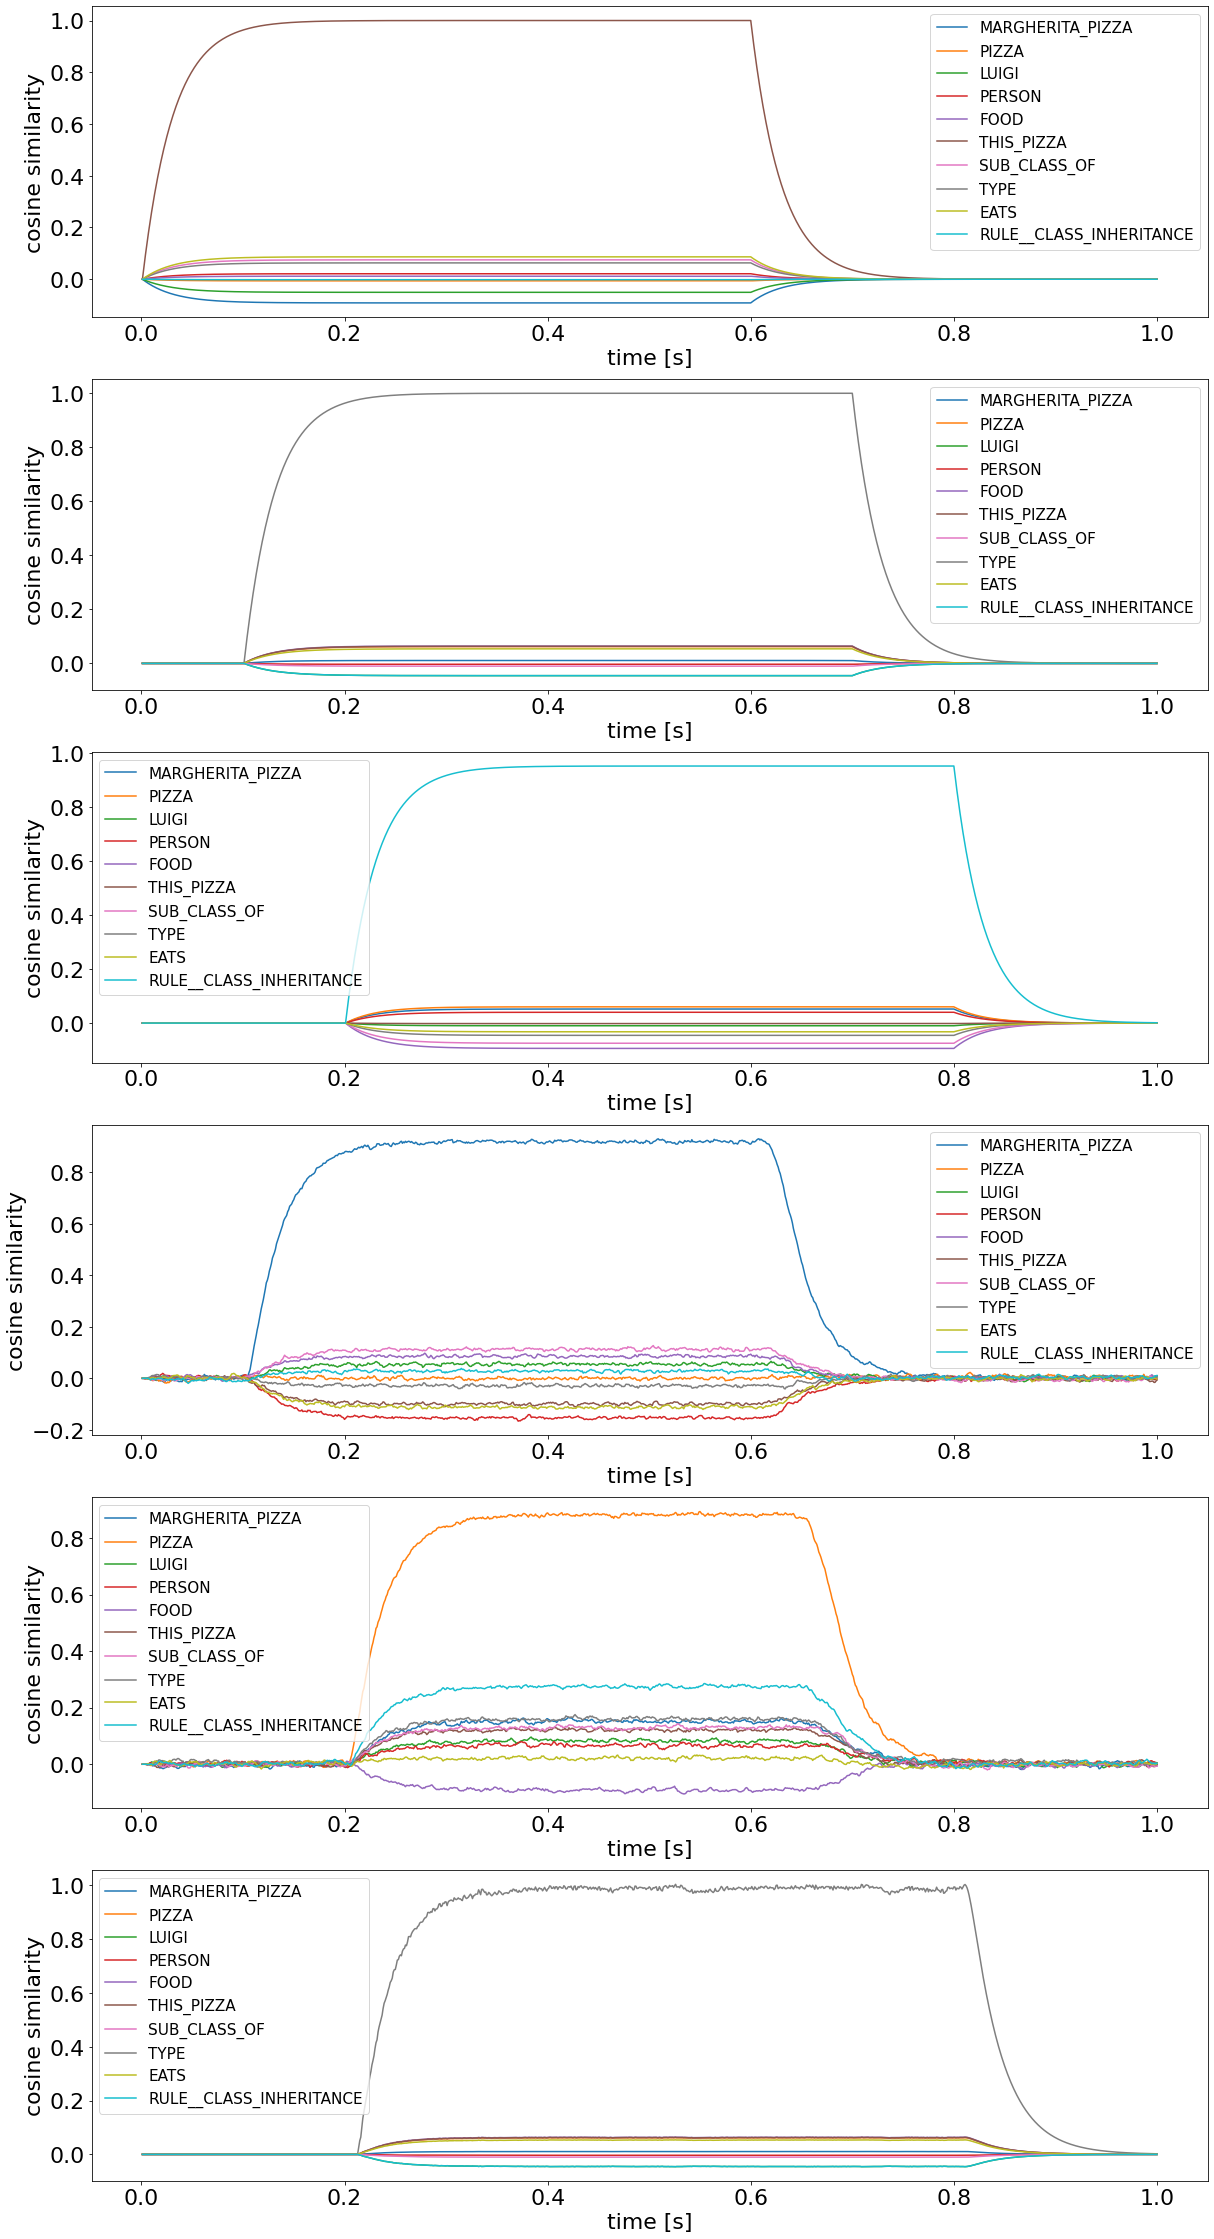

In [52]:
plt.figure(figsize=(20, 40))
plt.rcParams.update({'font.size': 22})


#vocab_dim = model.vocabs[dim]
vocab_dim = vocab

#if "INFERRED_REL__THIS_PIZZA" not in vocab_dim.keys():
    #vocab_dim.populate("INFERRED_REL__THIS_PIZZA = PIZZA * TYPE")

plt.subplot(6, 1, 1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_subject_cue], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("subject cue: THIS_PIZZA")

plt.subplot(6, 1, 2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_predicate_cue], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("predicate cue: TYPE")

plt.subplot(6, 1, 3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_rule_cue], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper left")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("rule cue: TYPE (/) SUB_CLASS_OF")

plt.subplot(6, 1, 4)
plt.plot(sim.trange(), spa.similarity(sim.data[p_asserted_object], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper right")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("asserted object: MARGHERITA")

plt.subplot(6, 1, 5)
plt.plot(sim.trange(), spa.similarity(sim.data[p_inferred_object], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper left")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("inferred object: PIZZA")

plt.subplot(6, 1, 6)
plt.plot(sim.trange(), spa.similarity(sim.data[p_inferred_predicate], vocab_dim))
plt.legend(vocab_dim.keys(), fontsize="x-small", loc="upper left")
plt.xlabel("time [s]")
plt.ylabel("cosine similarity")
#plt.ylabel("inferred predicate: TYPE")

#plt.subplot(6, 1, 6)
#plt.plot(sim.trange(), spa.similarity(sim.data[p_inferred_statement], vocab_dim))
#plt.legend(vocab_dim.keys(), fontsize="x-small")
#plt.ylabel("inferred statement on subject THIS_PIZZA:\n INFERRED_REL__THIS_PIZZA = PIZZA * TYPE")
#plt.xlabel("time [s]")